In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark as ps
import pyspark.sql.types as types
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import to_timestamp

# Check into a recommender library called "surprise"

In [13]:
# review_df = pd.read_json('review.json')

In [99]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

review_df = spark.read.json("data/review.json")
# checkin_df = spark.read.json("data/checkin.json")
# tip_df = spark.read.json("data/tip.json")
user_df = spark.read.json("data/user.json")
business_df = spark.read.json("data/business.json")

In [229]:
# Displays the content of the DataFrame to stdout
review_df.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [6]:
# checkin_df.head()

In [7]:
# tip_df.head()

In [8]:
# photo_df.head()

In [245]:
# business_df.take(2)

In [228]:
# user_df.columns

# Basic Cleaning

In [113]:
# # Check for null values
# frames = [business_df, review_df, user_df]

# for df in frames:
#     for c in df.columns:
#         null_value_count = df.where(df[c] == None).count()
#         print('Column: {}\nNull count: {}\n\n'.format(c, str(null_value_count)))
    
# # This is not showing any null values for the moment, remain skeptical, possible misuse of spark

# Basic EDA

#### Which region should we select for proceeding with this study? 

In [293]:
def calculate_region_density(state, businesses, bus_reviews):
    num_businesses = businesses.filter((businesses.categories.like('%Restaurants%')) &
                                (business_df.state == state)).count()
    num_reviews = bus_reviews.filter((bus_reviews.categories.like('%Restaurants%')) &
                                (bus_reviews.state == state)).count()
    return num_reviews/num_businesses

def compare_region_densities(regions, businesses, bus_reviews):
    max_density = 0
    density_dict = {}
    for region in regions:
        density = calculate_region_density(region, businesses, bus_reviews)
        density_dict[region] = density
        if density > max_density:
            max_density = density
            max_region = region

    print('Best Region: {}\nBest Density: {}'.format(max_region, max_density))
    return density_dict

Best Region: NV
Best Density: 178.80932802261339


Text(0.5, 1.0, 'Review Density by Region')

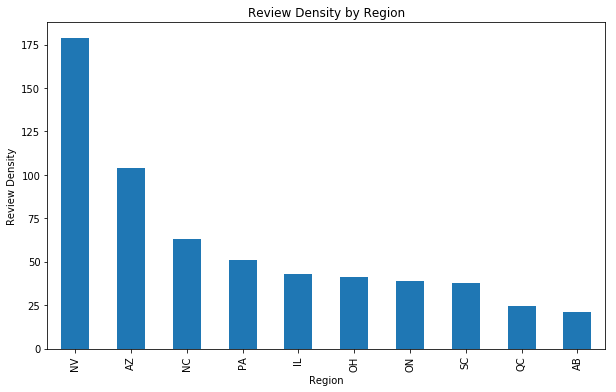

In [294]:
regions = ['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'IL', 'SC', 'QC']

density_dict = compare_region_densities(regions, business_df, bus_review_df)

pd.DataFrame.from_dict(density_dict, orient = 'index').sort_values(0, ascending = False).plot.bar(legend = False, figsize = (10, 6))
plt.ylabel('Review Density')
plt.xlabel('Region')
plt.title('Review Density by Region')

In [289]:
# Count of distinct values for all fields in review_df:
this = business_df.agg(*(countDistinct(col(c)).alias(c) for c in business_df.columns))
this.show(1)

+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|  name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
| 151977|     67875|     192609|     93385|1204|51566|      2|  155162|   150404|145046|      17541|        1184|    9|   36|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+



# Query for restaurants in Bay Area and then convert to Pandas

In [35]:
# Make "star" columns unique on business_df and review_df to avoid confusion
business_df = business_df.withColumnRenamed("stars","avg_stars")
review_df = review_df.withColumnRenamed("stars","review_stars")

In [247]:
# Join business and review df's so that we can query based on
bus_review_df = review_df.join(business_df, review_df.business_id == business_df.business_id, how='left')

In [251]:
bus_review_df.filter(business_df.business_id == 'QXAEGFB4oINsVuTFxEYKFQ').show(1)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+-------------+--------------------+-----------+------------+-----+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|       city|               hours|is_open|     latitude|    longitude|                name|postal_code|review_count|stars|state|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+-------------+--------------------+-----------+---

In [223]:
restaurant_df = business_df.filter(business_df.categories.like('%Restaurants%'))
num_restaurants = restaurant_df.count()
print('There are {} restaurants in the dataset.'.format(num_restaurants))

There are 59371 restaurants in the dataset.


In [221]:
bsubset_df = business_df.filter((business_df.categories.like('%Restaurants%')) &
                                (business_df.state == 'AZ')                               
                               )
print('There are {} Arizona restaurants in the dataset.'.format(bsubset_df.count()))

There are 11465 Arizona restaurants in the dataset.


### Las Vegas
* Henderson
### Toronto
* Missassauga
* Markham
* North York
### Phoenix - 56,686
* Mesa
* Tempe
* Scottsdale
* Chandler
* Glendale
* Gilbert
* Peoria
* Surprise
### Calgary
### Pittsburgh
### Montreal
### Cleveland
### Madison, WI
### Champaign, IL